In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 21 14:36:17 2019

@author: lospe
"""

import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import io
import requests
from sklearn import metrics
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,recall_score, precision_score, f1_score

# Encode a numeric column as ziscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    print(fpr)
    print(tpr)
    print(thresholds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print stats and plots for a model
def model_report(pred,y_test,labels):
    #score = metrics.accuracy_score(y_test, pred)
    #rc=recall_score(y_test, pred, average= "weighted")
    #pc=precision_score(y_test, pred, average= "weighted")
    #f1=f1_score(y_test, pred, average= "weighted")
    
    print(classification_report(y_test, pred))
    
    plot_roc(pred,y_test)
    
    cm = confusion_matrix(y_test, pred)
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, labels)
    plt.show()    
    

#======Data Manipulation=======

df = pd.read_csv("./data/UNSW_NB15_training-set_csc215.csv")
df_test=pd.read_csv("./data/UNSW_NB15_test-set_csc215.csv") 

#dropping data with '-'
dash=df[df['service']=='-'].index
df.drop(dash,inplace=True)
dashTest=df_test[df_test['service']=='-'].index
df_test.drop(dashTest,inplace=True)

#removing row with trans_depth=131
td=df[df['trans_depth']=='131'].index
df.drop(td,inplace=True)

df1=df #Copying data to a diffrent dataframe (just in case need old dataframe)

#======Training Data=======
#Balancing Data
df1NormalCount=len(df1[df1['label'] == 1])
df1AttackCount=len(df1[df1['label'] == 0])

df1NormalSet=(df1[df1['label'] == 1])
df1AttackSet=(df1[df1['label'] == 0])

if (df1NormalCount>df1AttackCount):
    frames=[df1NormalSet.head(df1AttackCount),df1AttackSet.head(df1AttackCount) ]
    df1= pd.concat(frames)
else:
    frames=[df1NormalSet.head(df1NormalCount),df1AttackSet.head(df1NormalCount) ]
    df1= pd.concat(frames)


df1=pd.get_dummies(df1, columns=['proto','service','state'])#training set hot encoding

#dropping unnecessary columns
df1=df1.drop(['id','sjit','djit','sinpkt','dinpkt','tcprtt','synack','ackdat','swin',
               'dwin','ct_srv_dst','ct_dst_ltm','ct_src_ltm','ct_dst_sport_ltm', 'ct_src_dport_ltm','attack_cat'],axis=1)



#======Test Data=======
#df1Test=df_test
#dfTestNormalCount=len(df1Test[df1Test['label'] == 1])
#dfTestAttackCount=len(df1Test[df1Test['label'] == 0])

#dfTestNormalSet=(df1Test[df1Test['label'] == 1])
#dfTestAttackSet=(df1Test[df1Test['label'] == 0])

#if (dfTestNormalCount>dfTestAttackCount):
#    frames=[dfTestNormalSet.head(dfTestAttackCount),dfTestAttackSet.head(dfTestAttackCount) ]
#    df1Test= pd.concat(frames)
#else:
#    frames=[dfTestNormalSet.head(dfTestNormalCount),dfTestAttackSet.head(dfTestNormalCount) ]


df1Test=pd.get_dummies(df_test, columns=['proto','service','state'])#test set hot encoding

#dropping unnecessary columns
df1Test=df1Test.drop(['attack_cat','id','sjit','djit','sinpkt','dinpkt','tcprtt','synack','ackdat','swin',
               'dwin','ct_srv_dst','ct_dst_ltm','ct_src_ltm','ct_dst_sport_ltm', 'ct_src_dport_ltm'],axis=1)


#Train Data Zscores
encode_numeric_zscore(df1, 'spkts', mean=None, sd=None)
encode_numeric_zscore(df1, 'dpkts', mean=None, sd=None)
encode_numeric_zscore(df1, 'sload', mean=None, sd=None)
encode_numeric_zscore(df1, 'dload', mean=None, sd=None)
#encode_numeric_zscore(df1, 'sloss', mean=None, sd=None)
#encode_numeric_zscore(df1, 'dloss', mean=None, sd=None)
#encode_numeric_zscore(df1, 'sinpkt', mean=None, sd=None)
#encode_numeric_zscore(df1, 'dinpkt', mean=None, sd=None)
#encode_numeric_zscore(df1, 'swin', mean=None, sd=None)
#encode_numeric_zscore(df1, 'ct_state_ttl', mean=None, sd=None)

encode_numeric_zscore(df1, 'dtcpb', mean=None, sd=None)
encode_numeric_zscore(df1, 'stcpb', mean=None, sd=None)
#encode_numeric_zscore(df1, 'dwin', mean=None, sd=None)
#encode_numeric_zscore(df1, 'smean', mean=None, sd=None)
#encode_numeric_zscore(df1, 'dmean', mean=None, sd=None)
#encode_numeric_zscore(df1, 'response_body_len', mean=None, sd=None)


#Test Data Zscores

encode_numeric_zscore(df1Test, 'spkts', mean=None, sd=None)
encode_numeric_zscore(df1Test, 'dpkts', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'rate', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'sbytes', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'dbytes', mean=None, sd=None)
encode_numeric_zscore(df1Test, 'sload', mean=None, sd=None)
encode_numeric_zscore(df1Test, 'dload', mean=None, sd=None)
encode_numeric_zscore(df1Test, 'dtcpb', mean=None, sd=None)
encode_numeric_zscore(df1Test, 'stcpb', mean=None, sd=None)

#encode_numeric_zscore(df1Test, 'sloss', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'dloss', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'sinpkt', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'dinpkt', mean=None, sd=None)
#  encode_numeric_zscore(df1Test, 'swin', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'ct_state_ttl', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'stcpb', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'dtcpb', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'dwin', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'smean', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'dmean', mean=None, sd=None)
#encode_numeric_zscore(df1Test, 'response_body_len', mean=None, sd=None)




dfTestList=df1Test[df1.columns.intersection(df1Test.columns)]#feeding only intersecting column's data for testing
dftrainList=df1[df1.columns.intersection(df1Test.columns)]#feeding only intersecting column's data for training

dfTrainObj = pd.DataFrame(dftrainList)
dfTRainObj=dfTrainObj.head(9625)

CleanTrainDF=dfTrainObj.values

dfTestObj = pd.DataFrame(dfTestList) 
dfTestObj=dfTestObj.head(19488)
CleanTestDF=dfTestObj.values
colnames=dfTrainObj.columns.values

y_train= dfTrainObj['label']
dfTrainObj.drop('label',1,inplace=True)
x_train=dfTrainObj

y_test= dfTestObj['label']
dfTestObj.drop('label',1,inplace=True)
x_test=dfTestObj
labels= ['Normal','Attack']

C:\Users\Mochu\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


W0924 17:54:23.771778 28636 deprecation.py:506] From C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


              precision    recall  f1-score   support

           0       0.85      0.99      0.91      4430
           1       1.00      0.95      0.97     15058

    accuracy                           0.96     19488
   macro avg       0.92      0.97      0.94     19488
weighted avg       0.96      0.96      0.96     19488

[0.         0.01038375 1.        ]
[0.         0.94727055 1.        ]
[2 1 0]


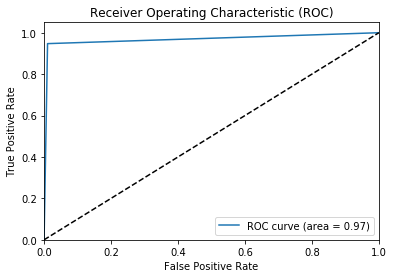

[[ 4384    46]
 [  794 14264]]


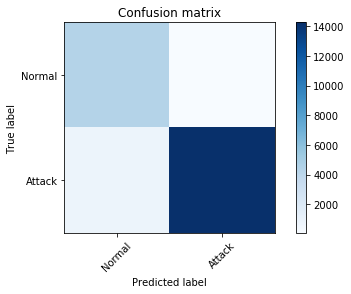

In [2]:
#Model 1

model = Sequential()

model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(25, activation='relu')) 
model.add(Dense(12, activation='relu')) 
model.add(Dense(2, activation="softmax")) # Output


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
checkpointer = ModelCheckpoint(filepath="./dnn/proj1a.hdf5", verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto') 
#y_train = to_categorical(y_train)

model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=100)
model.load_weights('./dnn/proj1a.hdf5') # load weights from best model

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
  
model_report(pred,y_test,labels)


C:\Users\Mochu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4430
           1       0.77      1.00      0.87     15058

    accuracy                           0.77     19488
   macro avg       0.39      0.50      0.44     19488
weighted avg       0.60      0.77      0.67     19488

[0. 1.]
[0. 1.]
[2 1]


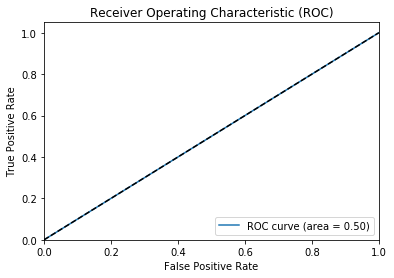

[[    0  4430]
 [    0 15058]]


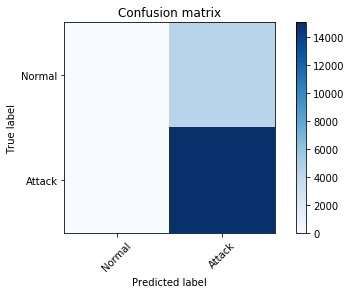

In [3]:
#Model 2
model = Sequential()

model.add(Dense(50, input_dim=x_train.shape[1], activation='relu')) 
model.add(Dense(25, activation='relu')) 
model.add(Dense(12, activation="relu")) 
model.add(Dense(2, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd')
checkpointer = ModelCheckpoint(filepath="./dnn/proj1a.hdf5", verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')  
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=100)
model.load_weights('./dnn/proj1a.hdf5') # load weights from best model

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)

model_report(pred,y_test,labels)


              precision    recall  f1-score   support

           0       0.95      0.86      0.91      4430
           1       0.96      0.99      0.97     15058

    accuracy                           0.96     19488
   macro avg       0.96      0.93      0.94     19488
weighted avg       0.96      0.96      0.96     19488

[0.         0.13611738 1.        ]
[0.         0.98744853 1.        ]
[2 1 0]


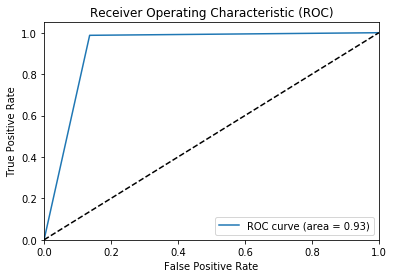

[[ 3827   603]
 [  189 14869]]


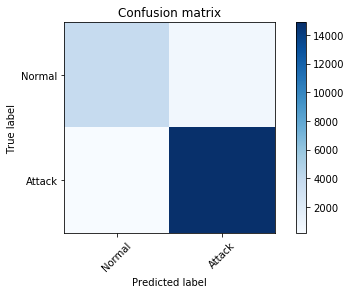

In [5]:
#Model 3

model2 = Sequential()

model2.add(Dense(25, input_dim=x_train.shape[1], activation='tanh')) 
model2.add(Dense(15, activation='tanh'))
model2.add(Dense(7, activation='tanh'))
model2.add(Dense(2, activation="softmax")) # Output

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
checkpointer = ModelCheckpoint(filepath="./dnn/proj1b.hdf5", verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')  
model2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=1000)
model2.load_weights('./dnn/proj1b.hdf5') # load weights from best azizimodel

pred = model2.predict(x_test)
pred = np.argmax(pred,axis=1) 


model_report(pred,y_test,labels)

              precision    recall  f1-score   support

           0       0.22      0.72      0.33      4430
           1       0.74      0.24      0.36     15058

    accuracy                           0.35     19488
   macro avg       0.48      0.48      0.35     19488
weighted avg       0.62      0.35      0.35     19488

[0.         0.27765237 1.        ]
[0.         0.23575508 1.        ]
[2 1 0]


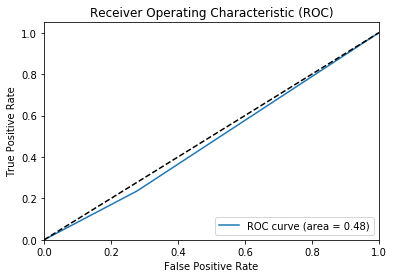

[[ 3200  1230]
 [11508  3550]]


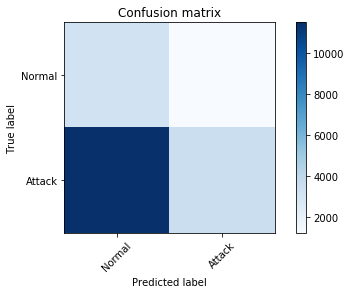

In [6]:
#Model 4
model2 = Sequential()

model2.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))  
model2.add(Dense(25, activation='sigmoid'))
model2.add(Dense(12, activation='sigmoid'))
model2.add(Dense(2, activation="softmax")) # Output

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
checkpointer = ModelCheckpoint(filepath="./dnn/proj1b.hdf5", verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=0, mode='auto')  
model2.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=1000)
model2.load_weights('./dnn/proj1b.hdf5')
pred = model2.predict(x_test)
pred = np.argmax(pred,axis=1)

model_report(pred,y_test,labels)


              precision    recall  f1-score   support

           0       0.22      0.72      0.33      4430
           1       0.74      0.24      0.36     15058

    accuracy                           0.35     19488
   macro avg       0.48      0.48      0.35     19488
weighted avg       0.62      0.35      0.35     19488

[0.         0.27765237 1.        ]
[0.         0.23575508 1.        ]
[2 1 0]


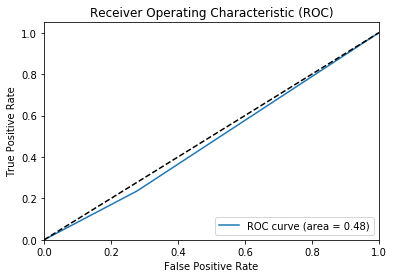

[[ 3200  1230]
 [11508  3550]]


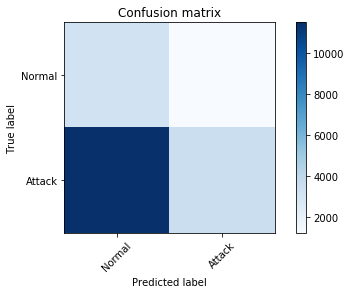

In [7]:
#Model 5
model3 = Sequential()

model3.add(Dense(25, input_dim=x_train.shape[1], activation='relu'))  
model3.add(Dense(25, activation='relu'))
model3.add(Dense(25, activation='relu')) 
model3.add(Dense(2, activation="softmax")) # Output

model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
checkpointer = ModelCheckpoint(filepath="./dnn/proj1b.hdf5", verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=0, mode='auto')  
model3.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=100)
model3.load_weights('./dnn/proj1b.hdf5') 

pred = model2.predict(x_test)
pred = np.argmax(pred,axis=1) 

model_report(pred,y_test,labels)

0
1
2
3
Training finished...Loading the best model

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4430
           1       0.99      1.00      0.99     15058

    accuracy                           0.99     19488
   macro avg       0.99      0.98      0.98     19488
weighted avg       0.99      0.99      0.99     19488

[0.         0.03792325 1.        ]
[0.         0.99601541 1.        ]
[2 1 0]


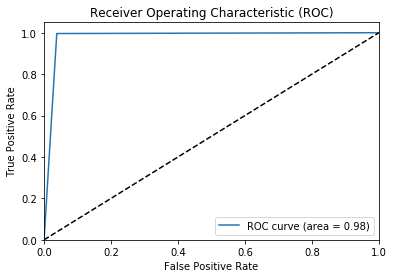

[[ 4262   168]
 [   60 14998]]


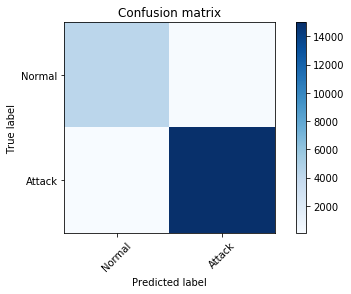

In [8]:
#Model 6
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    print(i)

    # Build network
  
    model = Sequential()

    model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(25, activation='relu')) 
    model.add(Dense(12, activation='relu'))
    model.add(Dense(2, activation="softmax")) # Output
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=0, mode='auto') 
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=1000)


pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)


print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

model_report(pred,y_test,labels)

0
1
2
3
Training finished...Loading the best model

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4430
           1       1.00      0.97      0.99     15058

    accuracy                           0.98     19488
   macro avg       0.96      0.98      0.97     19488
weighted avg       0.98      0.98      0.98     19488

[0.         0.01038375 1.        ]
[0.         0.97343605 1.        ]
[2 1 0]


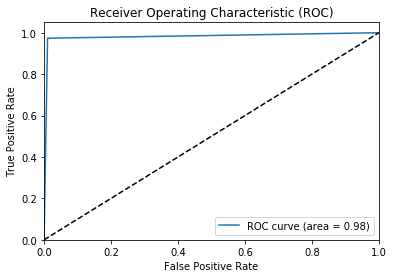

[[ 4384    46]
 [  400 14658]]


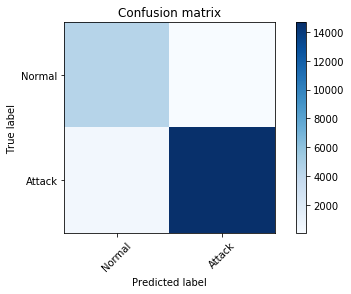

In [9]:
#Model 7
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    print(i)

    # Build network
  
    model = Sequential()

    model.add(Dense(25, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(15, activation='relu')) 
    model.add(Dense(2, activation="softmax")) # Output
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=0, mode='auto') 
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=1000)


pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)


print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

model_report(pred,y_test,labels)


Epoch 00001: val_loss improved from inf to 0.76481, saving model to ./dnn/proj1b.hdf5

Epoch 00002: val_loss did not improve from 0.76481

Epoch 00003: val_loss did not improve from 0.76481

Epoch 00004: val_loss did not improve from 0.76481

Epoch 00005: val_loss did not improve from 0.76481

Epoch 00006: val_loss did not improve from 0.76481

Epoch 00007: val_loss improved from 0.76481 to 0.67990, saving model to ./dnn/proj1b.hdf5

Epoch 00008: val_loss improved from 0.67990 to 0.55650, saving model to ./dnn/proj1b.hdf5

Epoch 00009: val_loss improved from 0.55650 to 0.43640, saving model to ./dnn/proj1b.hdf5

Epoch 00010: val_loss improved from 0.43640 to 0.29656, saving model to ./dnn/proj1b.hdf5

Epoch 00011: val_loss improved from 0.29656 to 0.26841, saving model to ./dnn/proj1b.hdf5

Epoch 00012: val_loss improved from 0.26841 to 0.24138, saving model to ./dnn/proj1b.hdf5

Epoch 00013: val_loss did not improve from 0.24138

Epoch 00014: val_loss improved from 0.24138 to 0.22720

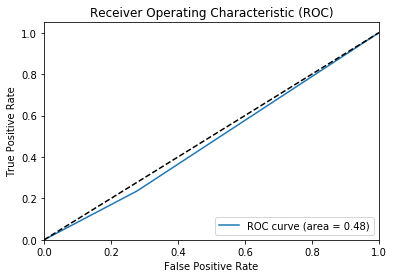

[[ 3200  1230]
 [11508  3550]]


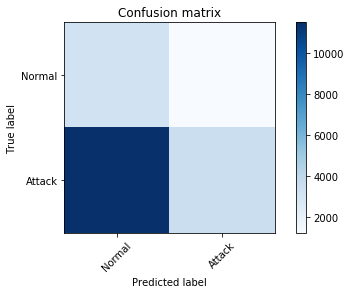

In [10]:
#Model Bad
model3 = Sequential()

model3.add(Dense(50, input_dim=x_train.shape[1], activation='sigmoid'))  
model3.add(Dense(25, activation='sigmoid'))
model3.add(Dense(10, activation='sigmoid'))
model3.add(Dense(2, activation="softmax")) 

model3.compile(loss='sparse_categorical_crossentropy', optimizer='sgd')
checkpointer = ModelCheckpoint(filepath="./dnn/proj1b.hdf5", verbose=2, save_best_only=True) 
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=0, mode='auto')  
model3.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=0, epochs=1000)
model3.load_weights('./dnn/proj1b.hdf5') # load weights from best model

pred = model2.predict(x_test)
pred = np.argmax(pred,axis=1) 

model_report(pred,y_test,labels)